# Toward a Better Footy Tipping Model, part 1: An Analysis of Basic Heuristics

Footy tipping is the popular Australian past time of picking which Australian Rules Football (AFL) teams will win their matches every week (like filling out a March Madness bracket, except it's done a round at a time, and the umpires make their fingers into pistols when a team scores). Each tipper gets a point for correctly picking the winner and a point in the case of a draw. At the end of the season, the winner is the one with the most points, with predicting the margin of the first match of each round serving as a tie-breaker.

There are a variety of heuristics that one could use to pick the winners and losers for the week. In my conversations with tippers and footy fans, I've found that the average participant tends to take in data, such as which team is favoured, which is the home team, how well each team has been playing lately, and whom they expect fellow competitors to tip, then process the input in their gut, arriving, in this way, at their predictions for the round.

Below, I will present a few basic heuristics for predicting match results, comparing their respective accuracies, following with a deeper analysis of the biases contained in the betting odds for AFL match results.

In [1]:
# We begin by importing dependencies and setting the random seed for reproducibility

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

np.random.seed(42)

In [2]:
# We load the cleaned data file created by scraping the AFL stats site footywire.com.au

df = pd.read_csv('../data/full_data.csv')
# Betting data only goes back to 2010, so dropping earlier years for consistency
df = (df[(df['year'] >= 2010)]
        # Note that bye weeks and seasons before newer teams existed mark most stats as 0,
        # including the opposing team's name
        .assign(draw=((df['score'] == df['oppo_score']) & (df['oppo_team'] != '0')).astype('int'))
        .fillna(0)
        .set_index(['team', 'year', 'round_number'], drop=False)
        .sort_index())

df

home_team  last_finals_reached  \
team             year round_number                                   
Adelaide         2010 1                   0.0                  2.0   
                      2                   1.0                  2.0   
                      3                   0.0                  2.0   
                      4                   1.0                  2.0   
                      5                   0.0                  2.0   
                      6                   1.0                  2.0   
                      7                   1.0                  2.0   
                      8                   0.0                  2.0   
                      9                   1.0                  2.0   
                      10                  0.0                  2.0   
                      11                  1.0                  2.0   
                      12                  0.0                  2.0   
                      13                  1.0                  2.0   
                      14                  1.0                  2.0   
                      15                  0.0                  2.0   
                      16                  1.0                  2.0   
                      17                  0.0                  2.0   
                      18                  0.0                  2.0   
                      19                  1.0                  2.0   
                      20                  0.0                  2.0   
                      21                  0.0                  2.0   
                      22                  1.0                  2.0   
                      23                  0.0                  0.0   
                      24                  0.0                  0.0   
                 2011 1                   1.0                  0.0   
                      2                   0.0                  0.0   
                      3                   1.0                  0.0   
                      4                   0.0                  0.0   
                      5                   0.0                  0.0   
                      6                   1.0                  0.0   
...                                       ...                  ...   
Western Bulldogs 2016 19                  0.0                  1.0   
                      20                  1.0                  1.0   
                      21                  1.0                  1.0   
                      22                  0.0                  1.0   
                      23                  0.0                  1.0   
                      24                  0.0                  0.0   
                 2017 1                   0.0                  4.0   
                      2                   1.0                  4.0   
                      3                   0.0                  4.0   
                      4                   0.0                  4.0   
                      5                   1.0                  4.0   
                      6                   0.0                  4.0   
                      7                   1.0                  4.0   
                      8                   0.0                  4.0   
                      9                   0.0                  4.0   
                      10                  1.0                  4.0   
                      11                  0.0                  0.0   
                      12                  0.0                  4.0   
                      13                  1.0                  4.0   
                      14                  1.0                  4.0   
                      15                  1.0                  4.0   
                      16                  0.0                  4.0   
                      17                  0.0                  4.0   
                      18                  1.0                  4.0   
                      19                  1.0 

In [3]:
# Next, we add some new columns calculated from the existing data

# Get cumulative stats by team & year, then group by team and shift one row
# in order to carry over end of last season for a team's first round ranking
def team_year_cum_col(df, stat_label):
    return (df.groupby(level=[0, 1])
              [stat_label]
              .cumsum()
              .groupby(level=[0])
              .shift()
              .fillna(0))

# Calculate cumulative stats by team & year
df.loc[:, 'cum_score'] = team_year_cum_col(df, 'score')
df.loc[:, 'cum_oppo_score'] = team_year_cum_col(df, 'oppo_score')
# In the AFL, percent (cumulative score / cumulative opponents' score) is used as a tie breaker
# for teams with the same number of win points
df.loc[:, 'cum_percent'] = df['cum_score'] / df['cum_oppo_score']
# For ladder rank, wins give a team 4 points; draws give both teams 2 points.
# Group and shift like other cumulative stats
df.loc[:, 'cum_win_points'] = (((df.groupby(level=[0, 1])['win'].cumsum() * 4) +
                                (df.groupby(level=[0, 1])['draw'].cumsum() * 2))
                               .groupby(level=[0])
                               .shift()
                               .fillna(0))

# Pivot to get round-by-round match points and cumulative percent
ladder_pivot_table = (df.loc[:, ['cum_win_points', 'cum_percent']]
                        .pivot_table(index=['year', 'round_number'],
                                     values=['cum_win_points', 'cum_percent'],
                                     columns='team',
                                     aggfunc={'cum_win_points': np.sum, 'cum_percent': np.mean}))

# To get round-by-round ladder ranks, we sort each round by win points & percent, then save index numbers
ladder_index = []
ladder_values = []

for idx, row in ladder_pivot_table.iterrows():
    sorted_row = (row.unstack(level=0)
                     .sort_values(['cum_win_points', 'cum_percent'], ascending=False))
    ladder_ranks = np.array(range(len(sorted_row)))
    
    
    for ladder_idx, team_name in enumerate(sorted_row.index.get_values()):
        ladder_index.append(tuple([team_name, *idx]))
        ladder_values.append(ladder_idx + 1)
        
ladder_ranks = pd.Series(ladder_values,
                         index=pd.MultiIndex.from_tuples(ladder_index, names=('team', 'year', 'round_number')),
                         name='ladder_rank')

# Add ladder_rank to df
df = pd.concat([df, ladder_ranks], axis=1)

# Get opponent's ladder rank
oppo_team_ladder = (df[df['oppo_team'] != '0']
                      .loc[:, ['oppo_team', 'ladder_rank']]
                      .reset_index()
                      .drop('team', axis=1)
                      # We switch out team for oppo_team in the index, then merge as oppo_ladder_rank
                      .rename(columns={'ladder_rank': 'oppo_ladder_rank', 'oppo_team': 'team'})
                      .set_index(['team', 'year', 'round_number'])
                      .sort_index())

# Add oppo_ladder_rank to ladder_df
df = pd.concat([df, oppo_team_ladder], axis=1).fillna(0)

df

home_team  last_finals_reached  \
team             year round_number                                   
Adelaide         2010 1                   0.0                  2.0   
                      2                   1.0                  2.0   
                      3                   0.0                  2.0   
                      4                   1.0                  2.0   
                      5                   0.0                  2.0   
                      6                   1.0                  2.0   
                      7                   1.0                  2.0   
                      8                   0.0                  2.0   
                      9                   1.0                  2.0   
                      10                  0.0                  2.0   
                      11                  1.0                  2.0   
                      12                  0.0                  2.0   
                      13                  1.0                  2.0   
                      14                  1.0                  2.0   
                      15                  0.0                  2.0   
                      16                  1.0                  2.0   
                      17                  0.0                  2.0   
                      18                  0.0                  2.0   
                      19                  1.0                  2.0   
                      20                  0.0                  2.0   
                      21                  0.0                  2.0   
                      22                  1.0                  2.0   
                      23                  0.0                  0.0   
                      24                  0.0                  0.0   
                 2011 1                   1.0                  0.0   
                      2                   0.0                  0.0   
                      3                   1.0                  0.0   
                      4                   0.0                  0.0   
                      5                   0.0                  0.0   
                      6                   1.0                  0.0   
...                                       ...                  ...   
Western Bulldogs 2016 19                  0.0                  1.0   
                      20                  1.0                  1.0   
                      21                  1.0                  1.0   
                      22                  0.0                  1.0   
                      23                  0.0                  1.0   
                      24                  0.0                  0.0   
                 2017 1                   0.0                  4.0   
                      2                   1.0                  4.0   
                      3                   0.0                  4.0   
                      4                   0.0                  4.0   
                      5                   1.0                  4.0   
                      6                   0.0                  4.0   
                      7                   1.0                  4.0   
                      8                   0.0                  4.0   
                      9                   0.0                  4.0   
                      10                  1.0                  4.0   
                      11                  0.0                  0.0   
                      12                  0.0                  4.0   
                      13                  1.0                  4.0   
                      14                  1.0                  4.0   
                      15                  1.0                  4.0   
                      16                  0.0                  4.0   
                      17                  0.0                  4.0   
                      18                  1.0                  4.0   
                      19                  1.0 

In [4]:
# Common column calculation across heuristics
def correct_tip(df):
    # Draws give all tippers a win
    return ((df['win'] == df['pred_win']) | (df['draw'] == 1)).astype('int')

## Comparison of Accuracies of Basic Heuristics

Below is a brief survey of simple, but reasonable, rules for tipping AFL matches. This certainly isn't a comprehensive list, but for a tipper who isn't really paying attention to how teams are playing these days, each heuristic represents a means of achieving an accuracy greater than 50% while using a single, easy-to-find data point.

### Heuristic 1: Always Tip the Home Team

Although few would pick the home team to win every match, it is a truth universally acknowledged that playing at home is preferable to playing away, so much so that playoff series are structured around the acceptance of this premise, and online tipping competitions punish non-tippers by defaulting to the visiting team.

In [5]:
# Always tip the home team

# Filter out bye weeks
home_df = (df[df['oppo_team'] != '0'].assign(pred_win=df['home_team']))
home_df.loc[:, 'correct_tip'] = correct_tip(home_df)
home_accuracy = home_df['correct_tip'].mean()

print('\nAlways Tip Home Team Accuracy: {0:.2f}%'.format(home_accuracy * 100))


Always Tip Home Team Accuracy: 57.29%


### Heuristic 2: Always Tip the Higher-Ranked Team

This, though simple, is probably closer to how a casual fan might tip: the parameters are a quick two-word Google search away (you don't even have to go to another website), and one is always picking the historically more-successful team from the start of the season to the current round. Of course, upsets do happen, and the difference between #1 and #15 is much greater than it is between #7 and #8.

In [6]:
# Always tip the higher-ranked team

ladder_df = df[df['oppo_team'] != '0'].copy()

# Filter out byes for predictions and accuracy calculations
ladder_df.loc[:, 'pred_win'] = (ladder_df['ladder_rank'] < ladder_df['oppo_ladder_rank']).astype('int')
# Draws give all tippers a win
ladder_df.loc[:, 'correct_tip'] = correct_tip(ladder_df)
ladder_accuracy = ladder_df['correct_tip'].mean()

print('\nAlways Tip Higher Ranked Accuracy: {0:.2f}%'.format(ladder_accuracy * 100))


Always Tip Higher Ranked Accuracy: 68.00%


### Heuristic 3: Always Tip the Odds-on Favourite

From the perspective of the end-user, this is a heuristic almost as simple as tipping the higher-ranked team, but it acts almost like a sophisticated black-box ensemble model: as far as we know, outsiders have access to the same data as oddsmakers, and we know that they're optimising for revenue, but we don't know what processes, what secret sauces, produce the line odds and point spreads that people bet on. Maybe a group of cragged, old men in fedoras and cheap suits smoke cigars and argue over exactly how many points Sydney are going to beat St. Kilda by; maybe a distributed deep-learning model, running on GPUs day and night, calculates odds to 100 significant digits every 5 minutes; maybe an augur watches the skies for how the birds are flying on any given day. In any case, the betting odds definitely represent an aggregation of far more data than any of the previous heuristics described.

In [7]:
# Always tip the betting-odds favourite

# Negative point spread indicates the favourite
def betting_pred_win(df):
    # point_spread == 0 means it's a coin flip
    return (((df['point_spread'] < 0) | ((df['point_spread'] == 0) & (np.random.rand() >= 0.5)))
            .astype('int'))
    
def point_spread_predictions(df):
    return df['point_spread'].apply(point_spread_prediction)

# Filter out bye weeks
favourite_df = (df[df['oppo_team'] != '0'].assign(pred_win=betting_pred_win))
# Draws give all tippers a win
favourite_df.loc[:, 'correct_tip'] = correct_tip(favourite_df)
favourite_accuracy = favourite_df['correct_tip'].mean()

print('\nAlways Tip Favourite Accuracy: {0:.2f}%'.format(favourite_accuracy * 100))


Always Tip Favourite Accuracy: 72.32%


### Summary of Heuristics

As the shown in the average accuracies above, a heuristic's reliability increases with the number of data inputs that its source takes into account.

* Calculating the home team just needs one datum: which team is at home.
* Calculating the higher-ranked team requires somewhat more: both teams' cumulative wins, draws, scores, and opponents' scores for the season.
* Finally, creating the odds for each match potentially takes into account all of the above plus each team's recent win percentage, their in-game stats, their players' individual stats, if any players are injured, head-to-head history for each matchup, and so on.

Since tipping the odds-on favourite is the most accurate heuristic by over 4%, I'll use this as the benchmark against which I'll measure the performance of the machine-learning model that I will develop later. Therefore, I'll focus further analysis on examining the biases built into betting odds, with the goal of using this information to help my model identify when to contradict the odds, hopefully achieving greater accuracy as a result.

## Analysis of Betting Odds

Now that we know that tipping based on betting odds alone offers the highest accuracy, let's explore under what conditions betting odds are more, or less, accurate. Given that the odds are determined through a feedback loop of betting companies setting the odds, then adjusting them based on how much people bet on the projected losers and winners in order to maximise revenue. Meanwhile, bettors risk their money based on perceived inefficiencies in the odds ("There's no way Carlton can lose to Melbourne by over 50!").

This means that betting odds represent a pretty good proxy for footy fans' conventional wisdom around each team's win probability. So, the question is if there are biases that tend to shape general perceptions of those win probabilities. Under what conditions are upsets more likely? If we can understand when and why the betting odds tend to be less accurate, we can emphasise those features when training a model in the hopes that it will be able to predict match results more accurately.

In [8]:
# Creating betting DF with betting-odds predictions

betting_df = df[df['oppo_team'] != '0'].assign(pred_win=betting_pred_win)
betting_df.loc[:, 'correct_pred'] = correct_tip(betting_df)

betting_df

home_team  last_finals_reached  \
team             year round_number                                   
Adelaide         2010 1                   0.0                  2.0   
                      2                   1.0                  2.0   
                      3                   0.0                  2.0   
                      4                   1.0                  2.0   
                      5                   0.0                  2.0   
                      6                   1.0                  2.0   
                      7                   1.0                  2.0   
                      8                   0.0                  2.0   
                      9                   1.0                  2.0   
                      10                  0.0                  2.0   
                      11                  1.0                  2.0   
                      12                  0.0                  2.0   
                      13                  1.0                  2.0   
                      14                  1.0                  2.0   
                      15                  0.0                  2.0   
                      16                  1.0                  2.0   
                      17                  0.0                  2.0   
                      18                  0.0                  2.0   
                      19                  1.0                  2.0   
                      20                  0.0                  2.0   
                      21                  0.0                  2.0   
                      22                  1.0                  2.0   
                 2011 1                   1.0                  0.0   
                      3                   1.0                  0.0   
                      4                   0.0                  0.0   
                      5                   0.0                  0.0   
                      6                   1.0                  0.0   
                      7                   0.0                  0.0   
                      8                   1.0                  0.0   
                      9                   0.0                  0.0   
...                                       ...                  ...   
Western Bulldogs 2016 16                  1.0                  1.0   
                      17                  1.0                  1.0   
                      18                  1.0                  1.0   
                      19                  0.0                  1.0   
                      20                  1.0                  1.0   
                      21                  1.0                  1.0   
                      22                  0.0                  1.0   
                      23                  0.0                  1.0   
                 2017 1                   0.0                  4.0   
                      2                   1.0                  4.0   
                      3                   0.0                  4.0   
                      4                   0.0                  4.0   
                      5                   1.0                  4.0   
                      6                   0.0                  4.0   
                      7                   1.0                  4.0   
                      8                   0.0                  4.0   
                      9                   0.0                  4.0   
                      10                  1.0                  4.0   
                      12                  0.0                  4.0   
                      13                  1.0                  4.0   
                      14                  1.0                  4.0   
                      15                  1.0                  4.0   
                      16                  0.0                  4.0   
                      17                  0.0                  4.0   
                      18                  1.0 

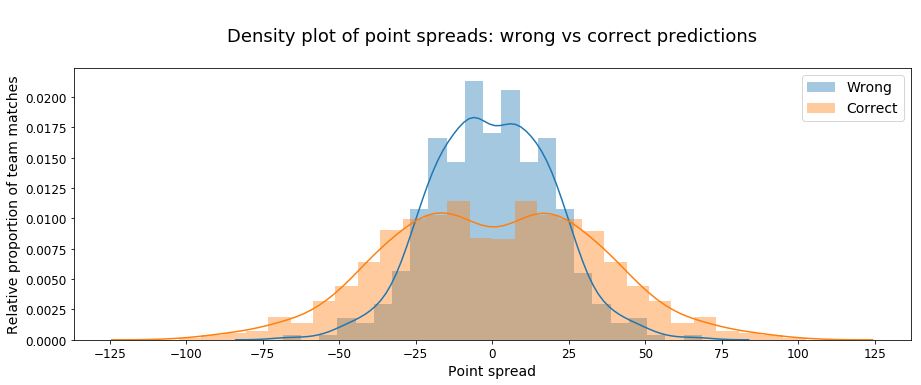

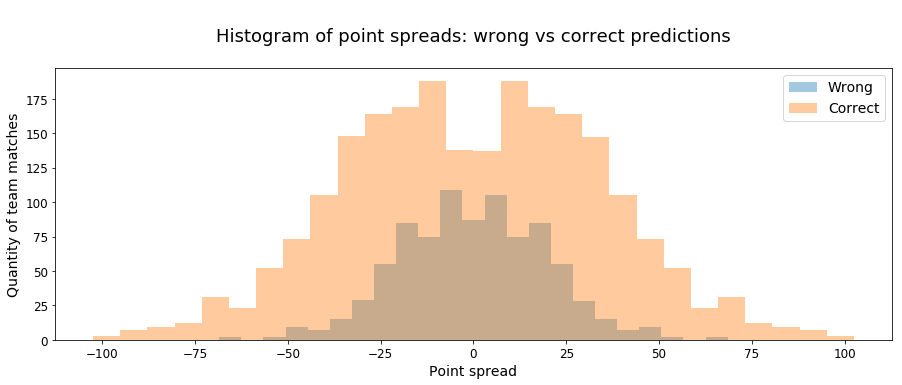

In [9]:
# When betting odds are wrong vs when they're correct

correct_point_spreads = betting_df[betting_df['correct_pred'] == 1]['point_spread']
wrong_point_spreads = betting_df[betting_df['correct_pred'] == 0]['point_spread']

# Kernel Density Estimate + Normed Histogram
plt.figure(figsize=(15,5))
plt.yticks(fontsize=12)
plt.xticks(np.linspace(-125, 125, num=11), fontsize=12)

sns.distplot(wrong_point_spreads, label='Wrong')
sns.distplot(correct_point_spreads, label='Correct')

plt.title('\nDensity plot of point spreads: wrong vs correct predictions\n', fontsize=18)
plt.ylabel('Relative proportion of team matches', fontsize=14)
plt.xlabel('Point spread', fontsize=14)
plt.legend(fontsize=14)

# Histogram
plt.figure(figsize=(15,5))
plt.yticks(fontsize=12)
plt.xticks(np.linspace(-125, 125, num=11), fontsize=12)

sns.distplot(wrong_point_spreads, label='Wrong', kde=False)
sns.distplot(correct_point_spreads, label='Correct', kde=False)

plt.title('\nHistogram of point spreads: wrong vs correct predictions\n', fontsize=18)
plt.ylabel('Quantity of team matches', fontsize=14)
plt.xlabel('Point spread', fontsize=14)
plt.legend(fontsize=14)

plt.show()

Betting odds are disproportionately wrong when the spread is small (roughly between -25 and 25 points). No surprise there. However, betting odds are correct more often than wrong at every point spread value, meaning that even for close matches, you're still better off tipping the favourite.

### Betting Odds for Home Teams

As we've shown, all other things being equal, home teams win slightly more often (~57%) than visiting teams. So, how do the oddsmakers take this into account? Do they have any biases with regards to home teams vs visiting teams?


% Home team is the favourite: 57.68%
Betting accuracy for home teams: 72.26%



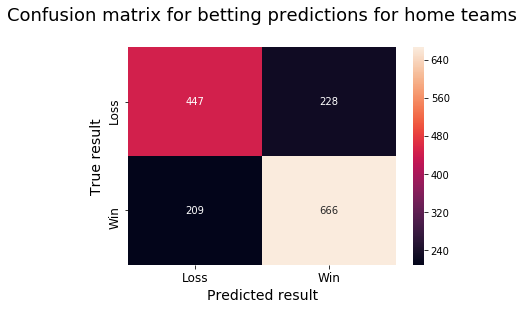

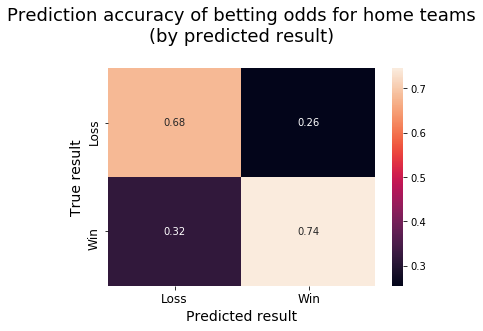

In [20]:
# Betting on home teams

home_bet_df = betting_df[betting_df['home_team'] == 1]

home_fave_rate = home_bet_df['pred_win'].mean()
home_fave_accuracy = home_bet_df['correct_pred'].mean()

print('\n% Home team is the favourite: {0:.2f}%'.format(home_fave_rate * 100))
print('Betting accuracy for home teams: {0:.2f}%\n'.format(home_fave_accuracy * 100))

home_cm = confusion_matrix(home_bet_df['win'], home_bet_df['pred_win'])
normal_home_cm = home_cm.astype('float') / home_cm.sum(axis=0)[np.newaxis, :]

sns.heatmap(home_cm, annot=True, fmt='d', xticklabels=['Loss', 'Win'], yticklabels=['Loss', 'Win'])
plt.title('Confusion matrix for betting predictions for home teams\n', fontsize=18)
plt.ylabel('True result', fontsize=14)
plt.xlabel('Predicted result', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()
print('')

sns.heatmap(home_cm.astype('float') / home_cm.sum(axis=0)[np.newaxis, :],
            annot=True, xticklabels=['Loss', 'Win'], yticklabels=['Loss', 'Win'])
plt.title('Prediction accuracy of betting odds for home teams\n(by predicted result)\n', fontsize=18)
plt.ylabel('True result', fontsize=14)
plt.xlabel('Predicted result', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()

Odds-makers are reasonably balanced in favouring home teams, picking them to win 57.68% of the time, which is in line with home teams' 57.29% win rate. The oddsmakers improve upon their overall accuracy by about 2% when picking the home team, suggesting that they're better at recognising when home-field advantage will be a deciding factor than when it won't.

### Betting Odds for Home Teams: Cross-State Matches

Beyond the widely-accepted impact of home-field advantage across sports and leagues, a quirk of the AFL's origins adds a wrinkle to our analysis. Aussie rules football began as a regional sport in the country's south and west, with rugby league being the dominant contact sport in the north and east. In fact, the Australian Football League used to be the Victorian Football League, and even now 10 of the league's 18 teams reside in the state of Victoria, their home stadiums little more than an hour's drive (1 hour, 2 minutes according to [Google Maps](https://www.google.com/maps/dir/MCG,+Brunton+Avenue,+Richmond+VIC/GMHBA+Stadium,+370+Moorabool+St,+South+Geelong+VIC+3220/@-37.9887757,144.5273674,11z/data=!3m1!4b1!4m14!4m13!1m5!1m1!1s0x6ad64295571a6281:0x63575fd647a0b2f9!2m2!1d144.9834493!2d-37.8199669!1m5!1m1!1s0x6ad4140d007cc031:0x54b5f173afaf1677!2m2!1d144.3545702!2d-38.1579763!3e0)) away from each other. So, the conventional wisdom about home field advantage, based on various conversations that I've had, is that it is minor, maybe even nonexistent, for teams from the same area and much more significant when the teams are from different states.

With this in mind, I'll look at cross-state matches to see if the impact of home field advantage is greater under these circumstances.

In [11]:
# Home vs away, in-state vs out-of-state

team_states_dict = {
    'Adelaide': 'SA',
    'Brisbane': 'QLD',
    'Carlton': 'VIC',
    'Collingwood': 'VIC',
    'Essendon': 'VIC',
    'Fitzroy': 'VIC',
    'Fremantle': 'WA',
    'GWS': 'NSW',
    'Geelong': 'VIC',
    'Gold Coast': 'QLD',
    'Hawthorn': 'VIC',
    'Melbourne': 'VIC',
    'North Melbourne': 'VIC',
    'Port Adelaide': 'SA',
    'Richmond': 'VIC',
    'South Melbourne': 'VIC',
    'St Kilda': 'VIC',
    'Sydney': 'NSW',
    'West Coast': 'WA',
    'Western Bulldogs': 'VIC',
    '0': '0'
}
# Adding venue states instead of just using team states, because sometimes matches are held
# in random places like Hobart, where no one has a real home-field advantage
venue_states_dict = {
    'Domain Stadium': 'WA',
    'AAMI Stadium': 'SA',
    'MCG': 'VIC',
    'Etihad Stadium': 'VIC',
    'Aurora Stadium': 'TAS',
    'Gabba': 'QLD',
    '0': '0',
    'GMHBA Stadium': 'VIC',
    'Metricon Stadium': 'QLD',
    'SCG': 'NSW',
    'Spotless Stadium': 'NSW',
    'Adelaide Oval': 'SA',
    'Blundstone Arena': 'TAS',
    'TIO Stadium': 'NT',
    'Westpac Stadium': 'NZ',
    'UTAS Stadium': 'TAS',
    'ANZ Stadium': 'NSW',
    'Blacktown International': 'NSW',
    'Manuka Oval': 'ACT',
    "Cazaly's Stadium": 'QLD',
    'Jiangwan Stadium': 'CH',
    'Mars Stadium': 'VIC'
}

geo_home_df = (betting_df.assign(team_state=betting_df['team'].apply(lambda x: team_states_dict[x]),
                                 oppo_team_state=betting_df['oppo_team'].apply(lambda x: team_states_dict[x]),
                                 venue_state=betting_df['venue'].apply(lambda x: venue_states_dict[x])))

# It only counts as a cross-state match if the home team is playing in their home state and the visiting team is not
geo_home_df.loc[:, 'cross_state_match'] = ((geo_home_df['team_state'] != geo_home_df['oppo_team_state']) &
                                           (geo_home_df['team_state'] == geo_home_df['venue_state'])).astype('int')


Home team win rate for cross-state matches: 58.16%
% Home team is the favourite for cross-state matches: 61.51%
Betting accuracy for home teams for cross-state matches: 72.65%



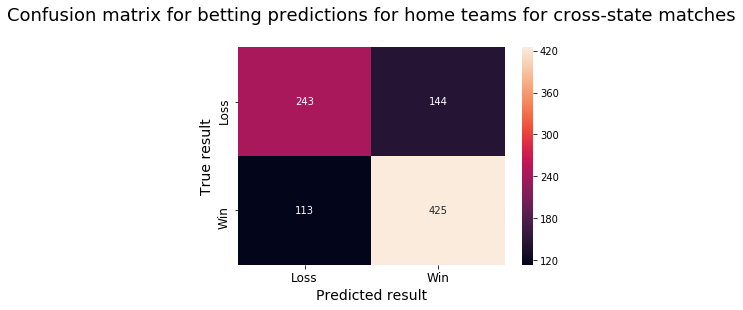

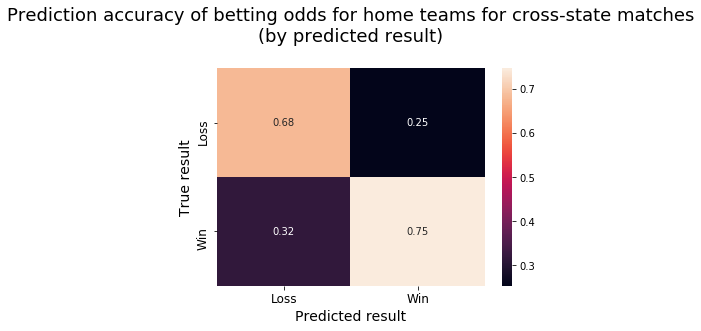

In [21]:
# Home team win % and betting odds for cross-state matches

cross_state_home_df = geo_home_df[(geo_home_df['cross_state_match'] == 1) & (geo_home_df['home_team'] == 1)]
cross_home_win_rate = cross_state_home_df['win'].mean()
cross_home_fave_rate = cross_state_home_df['pred_win'].mean()
cross_home_fave_accuracy = cross_state_home_df['correct_pred'].mean()

print('\nHome team win rate for cross-state matches: {0:.2f}%'.format(cross_home_win_rate * 100))
print('% Home team is the favourite for cross-state matches: {0:.2f}%'.format(cross_home_fave_rate * 100))
print('Betting accuracy for home teams for cross-state matches: {0:.2f}%\n'.format(cross_home_fave_accuracy * 100))

cross_home_cm = confusion_matrix(cross_state_home_df['win'], cross_state_home_df['pred_win'])
normal_home_cm = cross_home_cm.astype('float') / cross_home_cm.sum(axis=0)[np.newaxis, :]

sns.heatmap(cross_home_cm, annot=True, fmt='d', xticklabels=['Loss', 'Win'], yticklabels=['Loss', 'Win'])
plt.title('Confusion matrix for betting predictions for home teams for cross-state matches\n', fontsize=18)
plt.ylabel('True result', fontsize=14)
plt.xlabel('Predicted result', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()

sns.heatmap(cross_home_cm.astype('float') / cross_home_cm.sum(axis=0)[np.newaxis, :],
            annot=True, xticklabels=['Loss', 'Win'], yticklabels=['Loss', 'Win'])
plt.title('Prediction accuracy of betting odds for home teams for cross-state matches\n(by predicted result)\n',
          fontsize=18)
plt.ylabel('True result', fontsize=14)
plt.xlabel('Predicted result', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()

Home teams win 58.16% of cross-state matches, about one point more often than home teams overall, indicating a real, if small, effect from the extra travel distance. The oddsmakers, however, favour cross-state home teams 61.51% of the time, about three points more often, meaning that the conventional wisdom says that the cross-state effect is about three times what it actually is. This is evidence that betting odds tend to amplify conventional wisdom about the factors that contribute to teams' win probabilities. The accuracy of betting odds for cross-state matches is 72.65%, less than half a point higher than the their overall accuracy. The normalised confusion matrix also shows similar balance among prediction errors to what we see for all matches.

### Betting Odds for Higher-Ranked Teams

As demonstrated earlier, a stronger predictor of win probability than whether a team is playing at home is whether they are higher on the ladder than their opponent (~57% vs ~68%). As such, it makes sense for oddsmakers to generally favour higher-ranked teams. The question is how strong this tendency is and to what extent it is backed up by the actual performance of higher-ranked teams.


% Higher-ranked team is the favourite: 82.45%
Betting accuracy for higher-ranked teams: 72.19%



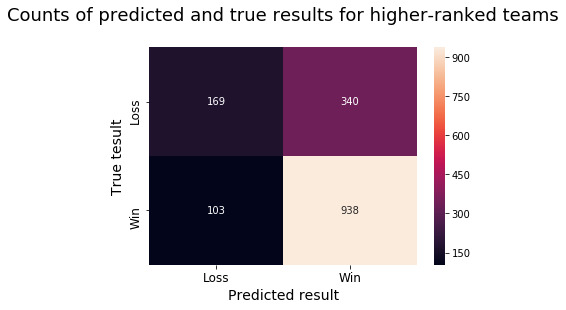

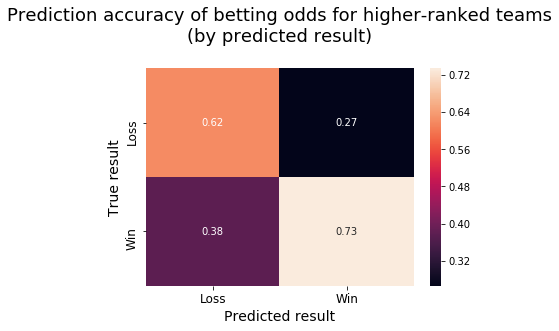

In [22]:
# Betting on higher-ranked teams

high_rank_bet_df = betting_df[betting_df['ladder_rank'] < betting_df['oppo_ladder_rank']]

high_rank_fave_rate = high_rank_bet_df['pred_win'].sum() / len(high_rank_bet_df)
high_rank_fave_accuracy = high_rank_bet_df['correct_pred'].sum() / len(high_rank_bet_df)

print('\n% Higher-ranked team is the favourite: {0:.2f}%'.format(high_rank_fave_rate * 100))
print('Betting accuracy for higher-ranked teams: {0:.2f}%\n'.format(high_rank_fave_accuracy * 100))

rank_cm = confusion_matrix(high_rank_bet_df['win'], high_rank_bet_df['pred_win'])

sns.heatmap(rank_cm, annot=True, fmt='d', xticklabels=['Loss', 'Win'], yticklabels=['Loss', 'Win'])
plt.title('Counts of predicted and true results for higher-ranked teams\n', fontsize=18)
plt.ylabel('True tesult', fontsize=14)
plt.xlabel('Predicted result', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()

sns.heatmap(rank_cm.astype('float') / rank_cm.sum(axis=0)[np.newaxis, :],
            annot=True, xticklabels=['Loss', 'Win'], yticklabels=['Loss', 'Win'])
plt.title('Prediction accuracy of betting odds for higher-ranked teams\n(by predicted result)\n', fontsize=18)
plt.ylabel('True result', fontsize=14)
plt.xlabel('Predicted result', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()

Although higher-ranked teams only win 68.00% of their matches, oddsmakers pick them to win 82.45% of the time, which is a much greater imbalance than we've seen with other segments.

Looking at the confusion matrices, we see that betting odds incorrectly favour the higher-ranked team more often than they favour the lower-ranked team at all. Furthermore, as with picking the home team - only more so - oddsmakers are significantly better at identifying when a better team (per their rank) will win than when a worse team will win.

It seems that the stronger the real effect is (home-field advantage, home-field advantage for cross-state matches, ladder rank as a predictor of wins) the more imbalanced betting odds become in favouring the teams that are supposed to win. Even if these biases don't seem to significantly affect the overall accuracy of betting odds, they do show some situations in which those odds are less accurate, namely when they are contrary to the conventional wisdom as to which teams should usually win.

### Betting Odds by Team

The AFL is closer to American sports leagues than European soccer leagues in how it is organised: There is a draft between seasons in which bad teams get first dibs on the top amateur players, there's a salary cap, there's a players union, etc. Many of these rules are meant to promote parity among teams, preventing a situation in which the same teams are going to the finals, while the same teams are languishing at the bottom of the ladder, year after year. Despite this, in talking to footy fans, I get the sense that some teams get a reputation for being perennial winners or losers, and these perceptions are slow to change.

In [14]:
# Group by teams

team_bet_df = (betting_df.groupby(level=0)[['win', 'pred_win', 'correct_pred']]
                         .mean()
                         .rename(columns={'win': 'win_rate', 'pred_win': 'pred_win_rate',
                                          'correct_pred': 'correct_pred_rate'}))
team_bet_df.loc[:, 'pred_win_diff'] = (team_bet_df['pred_win_rate'] - team_bet_df['win_rate'])

team_bet_df.sort_values('pred_win_diff')

,win_rate,pred_win_rate,correct_pred_rate,pred_win_diff
team,,,,
Brisbane,0.284091,0.210227,0.744318,-0.073864
Melbourne,0.312500,0.272727,0.715909,-0.039773
Gold Coast,0.259740,0.220779,0.818182,-0.038961
St Kilda,0.437500,0.403409,0.750000,-0.034091
Fremantle,0.551136,0.522727,0.767045,-0.028409
Richmond,0.505682,0.482955,0.676136,-0.022727
Essendon,0.431818,0.409091,0.704545,-0.022727
North Melbourne,0.511364,0.500000,0.715909,-0.011364
Western Bulldogs,0.471591,0.471591,0.738636,0.000000


As represented by the percent difference between the win rate and predicted win rate, there does seem to be a tendency to over-favour teams with winning records and under-favour teams with losing records. However, this doesn't seem to correlate with the accuracy of betting predictions, at least not linearly. Rather, the betting odds are relatively accurate for bad and good teams, and inaccurate for the mediocre teams.

In [15]:
# Group by team and year to get more data points

team_year_bet_df = (betting_df.groupby(level=[0, 1])
                         [['win', 'pred_win', 'correct_pred']]
                         .mean()
                         .rename(columns={'win': 'win_rate', 'pred_win': 'pred_win_rate',
                                          'correct_pred': 'correct_pred_rate'}))
team_year_bet_df.loc[:, 'pred_win_diff'] = team_year_bet_df['pred_win_rate'] - team_year_bet_df['win_rate']

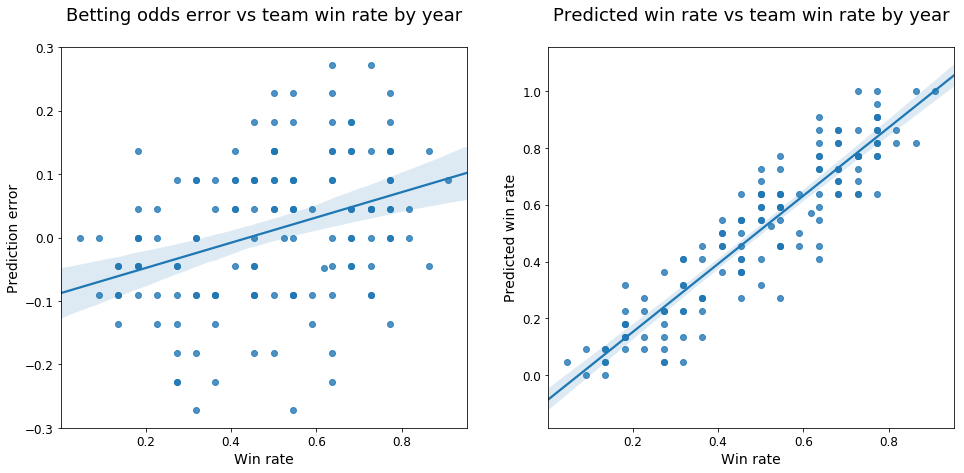

In [30]:
# Scatter plots for team-based win rates

print('')

plt.figure(figsize=(16,7))

plt.subplot(1, 2, 1)
sns.regplot(x='win_rate', y='pred_win_diff', data=team_year_bet_df.reset_index())

plt.title('Betting odds error vs team win rate by year\n', fontsize=18)
plt.ylabel('Prediction error', fontsize=14)
plt.xlabel('Win rate', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.subplot(1, 2, 2)
sns.regplot(x='win_rate', y='pred_win_rate', data=team_year_bet_df.reset_index())

plt.title('Predicted win rate vs team win rate by year\n', fontsize=18)
plt.ylabel('Predicted win rate', fontsize=14)
plt.xlabel('Win rate', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.show()

The relationship between teams' win rates and odds-makers' tendency to over-favour good teams and under-favour bad teams exists but is weak. It's certainly overwhelmed by the much stronger relationship between teams' win rate and their predicted win rate per betting odds, meaning that the pro-good-team bias doesn't significantly impact the accuracy of betting odds.

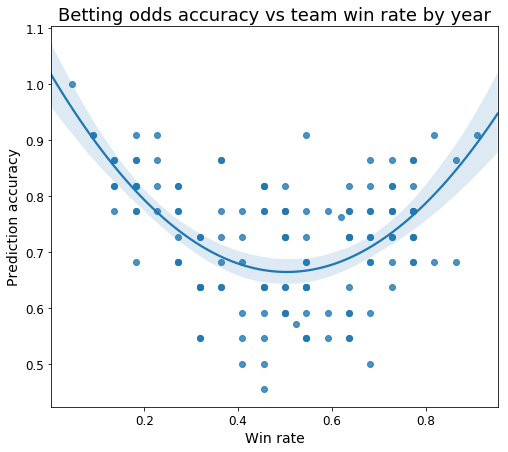

In [17]:
# Nonlinear scatter plot for accuracy and win rate

print('')

plt.figure(figsize=(8,7))

sns.regplot(x='win_rate', y='correct_pred_rate', data=team_year_bet_df.reset_index(), order=2)

plt.title('Betting odds accuracy vs team win rate by year', fontsize=18)
plt.ylabel('Prediction accuracy', fontsize=14)
plt.xlabel('Win rate', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.show()

The direct relationship between win rate and the accuracy of betting odds is more interesting, as it shows that oddsmakers are better at predicting results for bad teams and good teams, but have trouble with the mediocre teams that win between 40% and 60% of their matches. This fits with the general pattern of betting odds being less accurate when predicting the outcomes of close matches, which isn't a terribly interesting observation. Tipping the close matches is the hard part, but those are the ones that you need to get right in order to have a chance at winning the pot.

## In Conclusion

Among the simple heuristics explored here, the ones based on a larger number of data inputs tend to be better at predicting AFL match results, with betting odds being the most accurate predictor of all. Breaking down matches by different dimensions demonstrated some biases and weaknesses in oddsmakers' ability to predict winners and losers. Betting odds tend to amplify the conventional wisdom about the factors that contribute to victory, favouring teams that benefit from those factors at a higher rate than their win rate warrants. However, these biases have little impact on betting odds' performance, with lower accuracy generally centred around close matches, which are difficult to predict regardless of the quality and sophistication of one's methods.

One important dimension that I haven't covered is that of time. AFL match data can be aggregated by team or home vs away or higher- vs lower-ranked, but they represent discrete events that occur in a sequence, and past matches not only affect future matches, but trends in teams' performance on the field impact the conventional wisdom about who will win next week, which in turn affects the betting odds for next week's matches. Time is a large subject, however, so I will dig into it in the next post.